In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pickle
from itertools import product
%matplotlib inline

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm_notebook as tqdm

from joblib import Parallel, delayed

#Infrastructure
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import NotFittedError

#Data Handling
from sklearn.utils.validation import (
    check_X_y,
    check_array,
    NotFittedError,
)
from sklearn.utils.multiclass import check_classification_targets

#Utils
import numpy as np

from tqdm import tqdm
from sklearn.base import clone 
from sklearn.model_selection import KFold

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def homogenize_labels(a):
    u = np.unique(a)
    return np.array([np.where(u == i)[0][0] for i in a])

In [50]:

def _finite_sample_correction(posteriors, num_points_in_partition, num_classes):
    '''
    encourage posteriors to approach uniform when there is low data
    '''
    correction_constant = 1 / (num_classes * num_points_in_partition)

    zero_posterior_idxs = np.where(posteriors == 0)[0]

    c = len(zero_posterior_idxs) / (num_classes * num_points_in_partition)
    posteriors *= (1 - c)
    posteriors[zero_posterior_idxs] = correction_constant
    return posteriors

class UncertaintyForest(BaseEstimator, ClassifierMixin):
    '''
    based off of https://arxiv.org/pdf/1907.00325.pdf
    '''
    def __init__(
        self,
        max_depth=30,
        min_samples_leaf=1,
        max_samples = 0.32,
        max_features_tree = "auto",
        n_estimators=200,
        bootstrap=False,
        parallel=True):

        #Tree parameters.
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features_tree = max_features_tree

        #Bag parameters
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.max_samples = max_samples

        #Model parameters.
        self.parallel = parallel
        self.fitted = False

    def _check_fit(self):
        '''
        raise a NotFittedError if the model isn't fit
        '''
        if not self.fitted:
                msg = (
                        "This %(name)s instance is not fitted yet. Call 'fit' with "
                        "appropriate arguments before using this estimator."
                )
                raise NotFittedError(msg % {"name": type(self).__name__})

    def transform(self, X):
        '''
        get the estimated posteriors across trees
        '''
        X = check_array(X)
                
        def worker(tree_idx, tree):
            #get the nodes of X
            # Drop each estimation example down the tree, and record its 'y' value.
            return tree.apply(X)
            

        if self.parallel:
            return np.array(
                    Parallel(n_jobs=-1)(
                            delayed(worker)(tree_idx, tree) for tree_idx, tree in enumerate(self.ensemble.estimators_)
                    )
            )         
        else:
            return np.array(
                    [worker(tree_idx, tree) for tree_idx, tree in enumerate(self.ensemble.estimators_)]
                    )
        
    def get_transformer(self):
        return lambda X : self.transform(X)
        
    def vote(self, nodes_across_trees):
        return self.voter.predict(nodes_across_trees)
        
    def get_voter(self):
        return self.voter
        
                        
    def fit(self, X, y):

        #format X and y
        X, y = check_X_y(X, y)
        check_classification_targets(y)
        self.classes_, y = np.unique(y, return_inverse=True)
        
        #define the ensemble
        self.ensemble = BaggingClassifier(
            DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features_tree
            ),
            n_estimators=self.n_estimators,
            max_samples=self.max_samples,
            bootstrap=self.bootstrap,
            n_jobs = -1
        )
        
        #fit the ensemble
        self.ensemble.fit(X, y)
        
        class Voter(BaseEstimator):
            def __init__(self, estimators_samples_, classes, parallel = True):
                self.n_estimators = len(estimators_samples_)
                self.classes_ = classes
                self.parallel = parallel
                self.estimators_samples_ = estimators_samples_
            
            def fit(self, nodes_across_trees, y, fitting = False):
                self.tree_idx_to_node_ids_to_posterior_map = {}

                def worker(tree_idx):
                    nodes = nodes_across_trees[tree_idx]
                    cal_nodes = nodes[self.estimators_samples_[tree_idx]] if fitting else nodes
                    y_cal = y[self.estimators_samples_[tree_idx]] if fitting else y                    
                    
                    #create a map from the unique node ids to their classwise posteriors
                    node_ids_to_posterior_map = {}

                    #fill in the posteriors 
                    for node_id in np.unique(cal_nodes):
                        cal_idxs_of_node_id = np.where(cal_nodes == node_id)[0]
                        cal_ys_of_node = y_cal[cal_idxs_of_node_id]
                        class_counts = [len(np.where(cal_ys_of_node == y)[0]) for y in np.unique(y) ]
                        posteriors = np.nan_to_num(np.array(class_counts) / np.sum(class_counts))

                        #finite sample correction
                        posteriors_corrected = _finite_sample_correction(posteriors, len(cal_idxs_of_node_id), len(self.classes_))
                        node_ids_to_posterior_map[node_id] = posteriors_corrected

                    #add the node_ids_to_posterior_map to the overall tree_idx map 
                    self.tree_idx_to_node_ids_to_posterior_map[tree_idx] = node_ids_to_posterior_map
                    
                for tree_idx in range(self.n_estimators):
                        worker(tree_idx)
                return self
                        
                        
            def predict_proba(self, nodes_across_trees):
                def worker(tree_idx):
                    #get the node_ids_to_posterior_map for this tree
                    node_ids_to_posterior_map = self.tree_idx_to_node_ids_to_posterior_map[tree_idx]

                    #get the nodes of X
                    nodes = nodes_across_trees[tree_idx]

                    posteriors = []
                    node_ids = node_ids_to_posterior_map.keys()

                    #loop over nodes of X
                    for node in nodes:
                        #if we've seen this node before, simply get the posterior
                        if node in node_ids:
                            posteriors.append(node_ids_to_posterior_map[node])
                        #if we haven't seen this node before, simply use the uniform posterior 
                        else:
                            posteriors.append(np.ones((len(np.unique(self.classes_)))) / len(self.classes_))
                    return posteriors

                if self.parallel:
                    return np.mean(
                            Parallel(n_jobs=-1)(
                                    delayed(worker)(tree_idx) for tree_idx in range(self.n_estimators)
                            ), axis = 0
                    )

                else:
                    return np.mean(
                            [worker(tree_idx) for tree_idx in range(self.n_estimators)], axis = 0)
                
        #get the nodes of the calibration set
        nodes_across_trees = self.transform(X) 
        self.voter = Voter(estimators_samples_ = self.ensemble.estimators_samples_, classes = self.classes_, parallel = self.parallel)
        self.voter.fit(nodes_across_trees, y, fitting = True)
        self.fitted = True

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=-1)]

    def predict_proba(self, X):
        return self.voter.predict_proba(self.transform(X))


In [51]:
class LifeLongForest():
    def __init__(self, acorn = None, verbose = False, model = "uf"):
        self.X_across_tasks = []
        self.y_across_tasks = []
        
        self.transformers_across_tasks = []
        
        #element [i, j] votes on decider from task i under representation from task j
        self.voters_across_tasks_matrix = []
        self.n_tasks = 0
        
        self.classes_across_tasks = []
        
        if acorn is not None:
            np.random.seed(acorn)
        
        self.verbose = verbose
        
        self.model = model
        
    def check_task_idx_(self, task_idx):
        if task_idx >= self.n_tasks:
            raise Exception("Invalid Task IDX")
    
    def new_forest(self, 
                   X, 
                   y, 
                   epochs = 100, 
                   lr = 5e-4, 
                   n_estimators = 10, 
                   max_samples = .63,
                   bootstrap = True,
                   max_depth = 30,
                   min_samples_leaf = 1,
                   acorn = None):
        
        #if self.model == "dnn":
        #    from honest_dnn import HonestDNN 
        #if self.model == "uf":
        #    from uncertainty_forest import UncertaintyForest
        
        self.X_across_tasks.append(X)
        self.y_across_tasks.append(y)
        
        if self.model == "dnn":
            new_honest_dnn = HonestDNN(verbose = self.verbose)
            new_honest_dnn.fit(X, y, epochs = epochs, lr = lr)
        if self.model == "uf":
            new_honest_dnn = UncertaintyForest(n_estimators = n_estimators,
                                               max_samples = max_samples,
                                               bootstrap = bootstrap,
                                               max_depth = max_depth,
                                               min_samples_leaf = min_samples_leaf,
                                               parallel = True)
            new_honest_dnn.fit(X, y)
        new_transformer = new_honest_dnn.get_transformer()
        new_voter = new_honest_dnn.get_voter()
        new_classes = new_honest_dnn.classes_
        
        self.transformers_across_tasks.append(new_transformer)
        self.classes_across_tasks.append(new_classes)
        
        #add one voter to previous task voter lists under the new transformation
        for task_idx in range(self.n_tasks):
            X_of_task, y_of_task = self.X_across_tasks[task_idx], self.y_across_tasks[task_idx]
            if self.model == "dnn":
                X_of_task_under_new_transform = new_transformer.predict(X_of_task) 
            if self.model == "uf":
                X_of_task_under_new_transform = new_transformer(X_of_task) 
            unfit_task_voter_under_new_transformation = clone(self.voters_across_tasks_matrix[task_idx][0])
            if self.model == "uf":
                unfit_task_voter_under_new_transformation.classes_ = self.voters_across_tasks_matrix[task_idx][0].classes_
            task_voter_under_new_transformation = unfit_task_voter_under_new_transformation.fit(X_of_task_under_new_transform, y_of_task)

            self.voters_across_tasks_matrix[task_idx].append(task_voter_under_new_transformation)
            
        #add n_tasks voters to new task voter list under previous transformations 
        new_voters_under_previous_task_transformation = []
        for task_idx in range(self.n_tasks):
            transformer_of_task = self.transformers_across_tasks[task_idx]
            if self.model == "dnn":
                X_under_task_transformation = transformer_of_task.predict(X)
            if self.model == "uf":
                X_under_task_transformation = transformer_of_task(X)
            unfit_new_task_voter_under_task_transformation = clone(new_voter)
            if self.model == "uf":
                unfit_new_task_voter_under_task_transformation.classes_ = new_voter.classes_
            new_task_voter_under_task_transformation = unfit_new_task_voter_under_task_transformation.fit(X_under_task_transformation, y)
            new_voters_under_previous_task_transformation.append(new_task_voter_under_task_transformation)
            
        #make sure to add the voter of the new task under its own transformation
        new_voters_under_previous_task_transformation.append(new_voter)
        
        self.voters_across_tasks_matrix.append(new_voters_under_previous_task_transformation)
        
        self.n_tasks += 1
        
    def _estimate_posteriors(self, X, representation = 0, decider = 0):
        self.check_task_idx_(decider)
        
        if representation == "all":
            representation = range(self.n_tasks)
        elif isinstance(representation, int):
            representation = np.array([representation])
        
        posteriors_across_tasks = []
        for transformer_task_idx in representation:
            transformer = self.transformers_across_tasks[transformer_task_idx]
            voter = self.voters_across_tasks_matrix[decider][transformer_task_idx]
            if self.model == "dnn":
                posteriors_across_tasks.append(voter.predict_proba(transformer.predict(X)))
            if self.model == "uf":
                posteriors_across_tasks.append(voter.predict_proba(transformer(X)))
        return np.mean(posteriors_across_tasks, axis = 0)
    
    def predict(self, X, representation = 0, decider = 0):
        task_classes = self.classes_across_tasks[decider]
        return task_classes[np.argmax(self._estimate_posteriors(X, representation, decider), axis = -1)] 

In [52]:
def cross_val_data(data_x, data_y, class_idx, total_cls=100, cv=1):
    x = data_x.copy()
    y = data_y.copy()
    idx = class_idx.copy()
    
    
    for i in range(total_cls):
        indx = np.roll(idx[i],(cv-1)*100)
        
        if i==0:
            #train_x = x[indx[0:500],:]
            train_x = x[indx[0:500],:]
            test_x = x[indx[500:600],:]
            #train_y = y[indx[0:500]]
            train_y = y[indx[0:500]]
            test_y = y[indx[500:600]]
        else:
            #train_x = np.concatenate((train_x, x[indx[0:500],:]), axis=0)
            train_x = np.concatenate((train_x, x[indx[0:500],:]), axis=0)
            test_x = np.concatenate((test_x, x[indx[500:600],:]), axis=0)
            #train_y = np.concatenate((train_y, y[indx[0:500]]), axis=0)
            train_y = np.concatenate((train_y, y[indx[0:500]]), axis=0)
            test_y = np.concatenate((test_y, y[indx[500:600]]), axis=0)
        
        
    return train_x, train_y, test_x, test_y

In [53]:
n_tasks = 10
train_file = '/data/Jayanta/continual-learning/train'
unpickled_train = unpickle(train_file)
train_keys = list(unpickled_train.keys())
fine_labels = np.array(unpickled_train[train_keys[2]])
labels = fine_labels

test_file = '/data/Jayanta/continual-learning/test'
unpickled_test = unpickle(test_file)
test_keys = list(unpickled_test.keys())
fine_labels = np.array(unpickled_test[test_keys[2]])
labels_ = fine_labels

data_x = np.concatenate((unpickled_train[b'data'], unpickled_test[b'data']), axis=0)
data_y = np.concatenate((labels, labels_), axis=0)

class_idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]

In [54]:
def exp(train_x, train_y, test_x, test_y, task, n_data, ntrees=100, acorn=None):
    
    if acorn is not None:
        np.random.seed(acorn)
    
    lf = LifeLongForest()
    lf.new_forest(
        train_x[task*5000:task*5000+n_data,:], homogenize_labels(train_y[task*5000:task*5000+n_data]),
        n_estimators=ntrees
    )
    
    lf_task=lf.predict(test_x[task*1000:(task+1)*1000,:], representation=0, decider=0)
     
    
    return (1 - np.sum(lf_task == homogenize_labels(test_y[task*1000:(task+1)*1000]))/1000)


In [56]:
n_data = np.arange(100,5100,100)

for task in range(10):
    error = np.zeros((len(n_data),6),dtype=float)
    
    for cv in range(1,7,1):
        train_x, train_y, test_x, test_y = cross_val_data(data_x,data_y,class_idx,cv=cv)
        error[:,cv-1] = Parallel(n_jobs=-2,verbose=1)(delayed(exp)(
            train_x, train_y, test_x, test_y, task, n, ntrees=100, acorn=cv
        ) for n in n_data
        )
    
    with open('../result/UF_'+str(task+1)+'.pickle','wb') as f:
        pickle.dump(error,f)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 47 concurrent workers.
[Parallel(n_jobs=-2)]: Done   8 out of  50 | elapsed:   28.3s remaining:  2.5min
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:   51.0s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 47 concurrent workers.
[Parallel(n_jobs=-2)]: Done   8 out of  50 | elapsed:   25.1s remaining:  2.2min
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:   49.5s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 47 concurrent workers.
[Parallel(n_jobs=-2)]: Done   8 out of  50 | elapsed:   24.5s remaining:  2.1min
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:   48.3s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 47 concurrent workers.
[Parallel(n_jobs=-2)]: Done   8 out of  50 | elapsed:   25.0s remaining:  2.2min
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:   49.1s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 47 concurrent workers.
[Parall

KeyboardInterrupt: 

In [39]:
np.std(error,axis=1,ddof=1)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00631401, 0.00360093, 0.00280476, 0.00263944, 0.00280476,
       0.00773736, 0.00301662, 0.00462241, 0.00720185, 0.00668331,
       0.00647045, 0.00736885, 0.00873499, 0.00924662, 0.00393277,
       0.00818942, 0.01101665, 0.01422205, 0.0103473 , 0.01150072,
       0.01050079, 0.01141344, 0.01087045, 0.01118332, 0.01148332,
       0.00624233, 0.01167333, 0.00649359, 0.01242041, 0.00717403,
       0.01140175, 0.00856543, 0.00722957, 0.00791623, 0.00404969,
       0.00741395, 0.00752773, 0.00744088, 0.0107966 , 0.00677249,
       0.00649359, 0.00584523, 0.01075949, 0.00950789, 0.01254857])

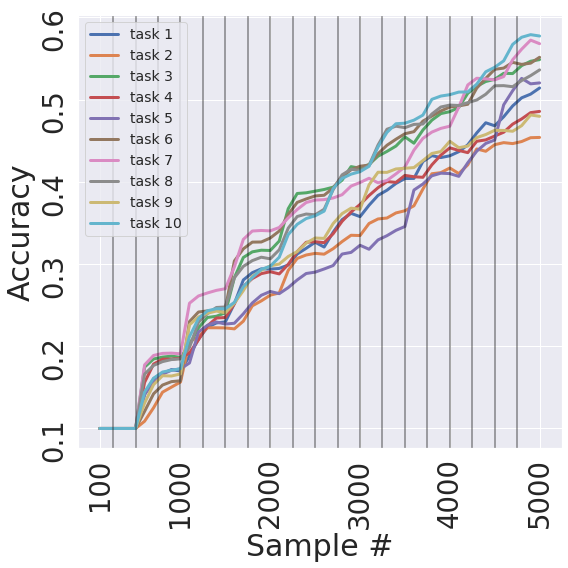

In [57]:
#sns.set()
n_data = np.arange(100,5100,100)
fig, ax = plt.subplots(1,1, figsize=(8,8))

for i in range(10):
    filename='../result/UF_'+str(i+1)+'.pickle'
    error = unpickle(filename)
    ax.plot(n_data,1-np.mean(error,axis=1), label = 'task '+str(i+1), markersize=14, linewidth=3)

ax.set_xticks([100,1000,2000,3000,4000,5000])
#ax.set_yticks([0.9, 1.0, 1.1, 1.2])
#ax.set_ylim(0.89, 1.21)
ax.tick_params(labelsize=27.5,rotation=90)
ax.legend(loc='upper left', fontsize=14)
# ax[0].legend(algos, bbox_to_anchor=(1.2, -.2), loc=2, borderaxespad=0)

ax.set_ylabel('Accuracy', fontsize=30)
ax.set_xlabel('Sample #', fontsize=30)

#ax.grid(axis='x')

for i in range(250,5000,250):
    ax.axvline(x = i, linewidth=1.5,alpha=0.5, color='k')

#ax.axvline(x = 3500, linewidth=3, color='k')

#ax.hlines(0.422, 1,5000, colors='k', linestyles='dashed',linewidth=2)

plt.tight_layout()


plt.savefig('/data/Jayanta/task.png',dpi=500)